In [1]:
#Imports

import math
import numpy as np 
from scipy import stats
from scipy.special import logit as lgTransform
from scipy.interpolate import UnivariateSpline
import pandas as pd
import statsmodels.api as sm 
import matplotlib.pylab as plt 
from sklearn.linear_model import LogisticRegression
import statsmodels.formula.api as smf
from statsmodels.formula.api import logit
import seaborn as sns
%matplotlib inline

In [2]:
#Load data

df = pd.read_csv('finalModelcsvs/fake_transcript_variants_syn_v5_chrom1_new.csv')
colDf = df.columns
print(colDf)
print("Number of columns: ", len(colDf))
print("Original df length: ", len(df))
print(df.head())

/Users/Admin/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (41,42,47,48,52,53) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Index(['chrom', 'pos', 'gene', 'ref', 'alt', 'freq', 'freq_nfe', 'mu', 'qual',
       'context', 'mean', 'median', 'over_t', 'over_5', 'over_10', 'over_15',
       'over_20', 'over_25', 'over_30', 'over_50', 'over_100', 'filter', 'an',
       'an_nfe', 'ac', 'ac_nfe', 'controls_an', 'controls_ac', 'non_cancer_an',
       'non_cancer_ac', 'BaseQRankSum', 'ClippingRankSum', 'DP', 'FS',
       'InbreedingCoeff', 'MQ', 'MQRankSum', 'QD', 'ReadPosRankSum', 'SOR',
       'VQSLOD', 'VQSR_NEGATIVE_TRAIN_SITE', 'VQSR_POSITIVE_TRAIN_SITE',
       'VQSR_culprit', 'allele_type', 'dp_hist_all_n_larger',
       'dp_hist_alt_n_larger', 'has_star', 'lcr', 'n_alt_alleles', 'pab_max',
       'rf_label', 'rf_negative_label', 'rf_positive_label',
       'rf_tp_probability_label', 'interp_dist', 'GIAB'],
      dtype='object')
Number of columns:  57
Original df length:  2215787
   chrom    pos             gene ref alt  freq  freq_nfe     mu qual context  \
0      1  69096  ENSG00000186092   G   C   0.0     

In [3]:
#Filtering out bad variants
#freq > 0 &  (ac==0 | filter!="PASS" | has_star | lcr | rf_label=="FP" | allele_type != "snv")

# dfGoodVariants = df[((df['freq'] > 0) & (df['ac'] == 0 | df['filter'] != 'PASS'
#                                         | df['has_star'] == True | df['lcr'] == True 
#                                         | df['rf_label'] == "FP" | df['allele_type'] != "snv"))]

dfBadVariants = df[df['freq'] > 0]
dfBadVariantsAlleleCount = dfBadVariants[dfBadVariants['ac'] == 0]
dfBadVariantsFilterQuality = dfBadVariants[dfBadVariants['filter'] != 'PASS']
dfBadVariantsHasStar = dfBadVariants[dfBadVariants['has_star'] == True]
dfBadVariantsLCR = dfBadVariants[dfBadVariants['lcr'] == True]
dfBadVariantsRFLabel = dfBadVariants[dfBadVariants['rf_label'] == 'FP']
dfBadVariantsAlleleType = dfBadVariants[dfBadVariants['allele_type'] != 'snv']

dfFinalBadVariants = pd.concat([dfBadVariantsAlleleCount, dfBadVariantsFilterQuality, dfBadVariantsHasStar, dfBadVariantsLCR, dfBadVariantsRFLabel, dfBadVariantsAlleleType], sort=False).sort_index()

print("AC: ", len(dfBadVariantsAlleleCount))
print("Filter: ", len(dfBadVariantsFilterQuality))
print("Has Star: ", len(dfBadVariantsHasStar))
print("LCR: ", len(dfBadVariantsLCR))
print("RF Label", len(dfBadVariantsRFLabel))
print("Allele Type", len(dfBadVariantsAlleleType))

print("Final bad variant set length: ", len(dfFinalBadVariants))
#print(dfFinalBadVariants.head())
#print(dfFinalBadVariants.tail(20))

#print(dfBadVariants['allele_type'].head())

#print("Filter out bad variants length: ", len(dfBadVariants))
#print(dfBadVariants.head())

AC:  15
Filter:  6945
Has Star:  13705
LCR:  274
RF Label 6238
Allele Type 0
Final bad variant set length:  27177


In [4]:
badIndexes = dfFinalBadVariants.index
badSites = dfFinalBadVariants.pos
print(dfFinalBadVariants.index)

df.drop(badIndexes, inplace = True)
dfGoodVariants = df
print(len(dfGoodVariants))
#print(dfGoodVariants.head())
#print(dfGoodVariants.tail())

Int64Index([    211,     212,     233,     247,     264,     314,     315,
                316,     400,     444,
            ...
            2214897, 2214901, 2215161, 2215172, 2215190, 2215302, 2215302,
            2215390, 2215721, 2215749],
           dtype='int64', length=27177)
2192503


In [5]:
#Coverage and quality filtering
# qual=="high", over_20>0.8,freq==0 & interp_dist==0 & allele_type != "snv", ENSG00000242265

print("Good variants length: ", len(dfGoodVariants))

#Keep sites with high quality
dfQuality = dfGoodVariants[dfGoodVariants['qual'] == 'high']
print("Quality filtering: ", len(dfQuality))

#Keep sites with over_20 coverage > 0.8
print("Hello", len(dfQuality))
dfFilterQuality80 = dfQuality[dfQuality['over_20'] > 0.8]
print("Hello", len(dfFilterQuality80))

#Change GIAB from T/F to binary variable
dfFilterQuality80["GIAB"] = dfFilterQuality80["GIAB"].astype(int)

#Filter freq == 0, #Filter interp_distance == 0, #Filter sites allele_type != "snv"
maskCoverage = (dfFilterQuality80['freq'] == 0) & (dfFilterQuality80['interp_dist'] == 0) & (dfFilterQuality80['allele_type'] != 'snv')

dfFilterQuality80FreqInterpAlleleType = dfFilterQuality80[maskCoverage]

# dfFilterQuality80 = dfFilterQuality80[dfFilterQuality80['freq'] != 0]
# dfFilterQuality80 = dfFilterQuality80[dfFilterQuality80['interp_dist'] != 0]
# dfFilterQuality80 = dfFilterQuality80[dfFilterQuality80['allele_type'] == 'snv']

freqInterpAlleleTypeIndexes = dfFilterQuality80FreqInterpAlleleType.index
print(freqInterpAlleleTypeIndexes)
dfFilterQuality80.drop(freqInterpAlleleTypeIndexes, inplace = True)
print(len(dfFilterQuality80))

#Filter sites in the gene ENSG00000242265
dfFilterQuality80 = dfFilterQuality80[dfFilterQuality80['gene'] != 'ENSG00000242265']
print(len(dfFilterQuality80))

#print(dfQuality.head())

print("After filtering for freq == 0 and interp_dist == 0: ", len(dfFilterQuality80))
#print(dfFilterQuality80.head())
#print(dfFilterQuality80.tail())

print(len(dfFilterQuality80FreqInterpAlleleType))
#print(dfFilterQuality80FreqInterpAlleleType.head())

Good variants length:  2192503
Quality filtering:  2046124
Hello 2046124
Hello 1632642


<ipython-input-5-932258d03584>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfFilterQuality80["GIAB"] = dfFilterQuality80["GIAB"].astype(int)


Int64Index([   1982,    1983,    1984,    2127,    2128,    2129,    2340,
               2429,    2977,    3757,
            ...
            2214780, 2214781, 2214782, 2215038, 2215039, 2215040, 2215045,
            2215046, 2215047, 2215093],
           dtype='int64', length=12496)


/Users/Admin/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


1620146
1620146
After filtering for freq == 0 and interp_dist == 0:  1620146
12496


In [6]:
dfFilterQuality80['CpG_context'] = [1 for x in range(len(dfFilterQuality80))]
#print(dfFilterQuality80.head())

In [7]:
#CpG Transitions

context = dfFilterQuality80.context.tolist()
ref = dfFilterQuality80.ref.tolist()
alt = dfFilterQuality80.alt.tolist()
CpGArray = np.zeros(len(context))
CpGArrayIndex = 0

for i in range(len(context)):
    contextString = context[i]
    for j in range(len(contextString)-1):
        if (contextString[j] == 'C' and contextString[j+1] == 'G'):
            if ((ref[i] == 'G' and alt[i] == 'A') or (ref[i] == 'C' and alt[i] == 'T')):
                CpGArray[CpGArrayIndex] = 1
    CpGArrayIndex = CpGArrayIndex + 1

# for k in range(100): 
#     print(CpGArray[k])
    
# print(dfFilterQuality80.context.head(50))
# print(len(CpGArray))

dfFilterQuality80['CpG_context'] = CpGArray.tolist()
#dfChuckles = dfFilterQuality80[['context', 'CpG_context']]
#print(dfChuckles.head(50))
print(dfFilterQuality80.head())

     chrom     pos             gene ref alt      freq  freq_nfe     mu  qual  \
629      1  925947  ENSG00000187634   C   A  0.000000  0.000000  0.020  high   
630      1  925947  ENSG00000187634   C   G  0.000000  0.000000  0.041  high   
631      1  925947  ENSG00000187634   C   T  0.000004  0.000009  0.139  high   
632      1  925950  ENSG00000187634   G   A  0.000004  0.000009  0.163  high   
633      1  925953  ENSG00000187634   G   A  0.000000  0.000000  0.261  high   

    context  ...    lcr  n_alt_alleles   pab_max  rf_label  rf_negative_label  \
629   TCCAA  ...  False            1.0  0.499897       NaN              False   
630   TCCAA  ...  False            1.0  0.499897       NaN              False   
631   TCCAA  ...  False            1.0  0.499897       NaN              False   
632   CCCTT  ...  False            1.0  0.114660       NaN              False   
633   ATCCC  ...  False            1.0  0.668285       NaN              False   

     rf_positive_label  rf_tp_pr

In [8]:
# dfCpG = dfFilterQuality80.loc[dfFilterQuality80['CpG_context'] == 1]
# ref = dfCpG.ref.tolist()
# alt = dfCpG.alt.tolist()
# CpGArrayTransitions = np.zeros(len(dfCpG))
# CpGTransitionsArrayIndex = 0

# for i in range(len(dfCpG)): 
#     if ((ref[i] == 'G' and alt[i] == 'A') or (ref[i] == 'C' and alt[i] == 'T')):
#         CpGArrayTransitions[CpGTransitionsArrayIndex] = 1
#     CpGTransitionsArrayIndex = CpGTransitionsArrayIndex + 1

# for k in range(100):
#     print(CpGArrayTransitions[k])

# #print(CpGArrayTransitions)
# print(len(dfCpG))
# print(dfCpG.head(50))

In [9]:
#Dependent var freq > 0 logistic_freq

dfFilterQuality80.insert(58, 'logistic_freq', [1 for x in range(len(dfFilterQuality80))])
dfFilterQuality80['logistic_freq'] = np.where((dfFilterQuality80.freq == 0), 0, dfFilterQuality80.logistic_freq)
print(dfFilterQuality80.head())

     chrom     pos             gene ref alt      freq  freq_nfe     mu  qual  \
629      1  925947  ENSG00000187634   C   A  0.000000  0.000000  0.020  high   
630      1  925947  ENSG00000187634   C   G  0.000000  0.000000  0.041  high   
631      1  925947  ENSG00000187634   C   T  0.000004  0.000009  0.139  high   
632      1  925950  ENSG00000187634   G   A  0.000004  0.000009  0.163  high   
633      1  925953  ENSG00000187634   G   A  0.000000  0.000000  0.261  high   

    context  ...  n_alt_alleles   pab_max  rf_label  rf_negative_label  \
629   TCCAA  ...            1.0  0.499897       NaN              False   
630   TCCAA  ...            1.0  0.499897       NaN              False   
631   TCCAA  ...            1.0  0.499897       NaN              False   
632   CCCTT  ...            1.0  0.114660       NaN              False   
633   ATCCC  ...            1.0  0.668285       NaN              False   

     rf_positive_label  rf_tp_probability_label  interp_dist  GIAB  \
629 

In [10]:
#log transform mu
dfFilterQuality80['log_mu'] = np.log10(dfFilterQuality80['mu'])
print(dfFilterQuality80.head())

     chrom     pos             gene ref alt      freq  freq_nfe     mu  qual  \
629      1  925947  ENSG00000187634   C   A  0.000000  0.000000  0.020  high   
630      1  925947  ENSG00000187634   C   G  0.000000  0.000000  0.041  high   
631      1  925947  ENSG00000187634   C   T  0.000004  0.000009  0.139  high   
632      1  925950  ENSG00000187634   G   A  0.000004  0.000009  0.163  high   
633      1  925953  ENSG00000187634   G   A  0.000000  0.000000  0.261  high   

    context  ...   pab_max  rf_label  rf_negative_label  rf_positive_label  \
629   TCCAA  ...  0.499897       NaN              False              False   
630   TCCAA  ...  0.499897       NaN              False              False   
631   TCCAA  ...  0.499897       NaN              False              False   
632   CCCTT  ...  0.114660       NaN              False              False   
633   ATCCC  ...  0.668285       NaN              False              False   

     rf_tp_probability_label  interp_dist  GIAB  C

In [11]:
#log transform mu^2
dfFilterQuality80['log_mu_squared'] = (np.log10(dfFilterQuality80['mu']))**2
print(dfFilterQuality80.head())

     chrom     pos             gene ref alt      freq  freq_nfe     mu  qual  \
629      1  925947  ENSG00000187634   C   A  0.000000  0.000000  0.020  high   
630      1  925947  ENSG00000187634   C   G  0.000000  0.000000  0.041  high   
631      1  925947  ENSG00000187634   C   T  0.000004  0.000009  0.139  high   
632      1  925950  ENSG00000187634   G   A  0.000004  0.000009  0.163  high   
633      1  925953  ENSG00000187634   G   A  0.000000  0.000000  0.261  high   

    context  ...  rf_label  rf_negative_label  rf_positive_label  \
629   TCCAA  ...       NaN              False              False   
630   TCCAA  ...       NaN              False              False   
631   TCCAA  ...       NaN              False              False   
632   CCCTT  ...       NaN              False              False   
633   ATCCC  ...       NaN              False              False   

     rf_tp_probability_label  interp_dist  GIAB  CpG_context  logistic_freq  \
629                      NaN   

In [12]:
#GIAB CpG Interaction
dfFilterQuality80['GIAB_CpG_Interaction'] = dfFilterQuality80['GIAB'] * dfFilterQuality80['CpG_context']
print(dfFilterQuality80.head())

     chrom     pos             gene ref alt      freq  freq_nfe     mu  qual  \
629      1  925947  ENSG00000187634   C   A  0.000000  0.000000  0.020  high   
630      1  925947  ENSG00000187634   C   G  0.000000  0.000000  0.041  high   
631      1  925947  ENSG00000187634   C   T  0.000004  0.000009  0.139  high   
632      1  925950  ENSG00000187634   G   A  0.000004  0.000009  0.163  high   
633      1  925953  ENSG00000187634   G   A  0.000000  0.000000  0.261  high   

    context  ...  rf_negative_label  rf_positive_label  \
629   TCCAA  ...              False              False   
630   TCCAA  ...              False              False   
631   TCCAA  ...              False              False   
632   CCCTT  ...              False              False   
633   ATCCC  ...              False              False   

     rf_tp_probability_label  interp_dist  GIAB  CpG_context  logistic_freq  \
629                      NaN            0     1          0.0              0   
630         

In [13]:
#Final model Loss of Function
print(dfFilterQuality80['median'].head())
final_mod = smf.glm('logistic_freq ~ mu + log_mu + log_mu_squared + GIAB + CpG_context + GIAB_CpG_Interaction + median', data = dfFilterQuality80, family = sm.families.Binomial()).fit()
print(final_mod.summary())

629    85
630    85
631    85
632    86
633    87
Name: median, dtype: int64
                 Generalized Linear Model Regression Results                  
Dep. Variable:          logistic_freq   No. Observations:              1620146
Model:                            GLM   Df Residuals:                  1620138
Model Family:                Binomial   Df Model:                            7
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -4.7301e+05
Date:                Mon, 06 Sep 2021   Deviance:                   9.4601e+05
Time:                        17:59:53   Pearson chi2:                 1.62e+06
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------

In [14]:
def calculateLogisticProbSynon(intercept, muMod, log_muMod, log_mu_squaredMod, GIABMod, CpG_contextMod, GIAB_CpG_InteractionMod, medianMod, mu, log_mu, log_mu_squared, GIAB, CpG_context, GIAB_CpG_Interaction, median):
        probability = 1 / (1 + math.exp(-1 * ((intercept + (mu * muMod) + (log_muMod * log_mu) + (log_mu_squared * log_mu_squaredMod) + (GIAB * GIABMod) + (CpG_contextMod * CpG_context) + (GIAB_CpG_InteractionMod * GIAB_CpG_Interaction) + (median * medianMod)))))
        return probability
        
interceptMod, muMod, log_muMod, log_mu_squaredMod, GIABMod, CpG_contextMod, GIAB_CpG_InteractionMod, medianMod = final_mod.params

#Test cases
mu0 = 0.020
log_mu0 = -1.698970
log_mu_squared0 = 2.886499
GIAB0 = 1 
CpG_context0 = 0
GIAB_CpG_Interaction0 = 0
median0 = 85

mu1 = 0.041
log_mu1 = -1.387216
log_mu_squared1 = 1.924369
GIAB1 = 1 
CpG_context1 = 0
GIAB_CpG_Interaction1 = 0
median1 = 85

print(calculateLogisticProbSynon(interceptMod, muMod, log_muMod, log_mu_squaredMod, GIABMod, CpG_contextMod, GIAB_CpG_InteractionMod, medianMod, mu0, log_mu0, log_mu_squared0, GIAB0, CpG_context0, GIAB_CpG_Interaction0, median0))
print(calculateLogisticProbSynon(interceptMod, muMod, log_muMod, log_mu_squaredMod, GIABMod, CpG_contextMod, GIAB_CpG_InteractionMod, medianMod, mu1, log_mu1, log_mu_squared1, GIAB1, CpG_context1, GIAB_CpG_Interaction1, median1))

0.02816726968675413
0.05856977654512853


In [15]:
dfFilterQuality80['probability_final_mod'] = [1 for x in range(len(dfFilterQuality80))]
probFinalModArray = np.zeros(len(dfFilterQuality80))

muArray = dfFilterQuality80.mu.tolist()
log_muArray = dfFilterQuality80.log_mu.tolist()
log_mu_squaredArray = dfFilterQuality80.log_mu_squared.tolist()
GIABArray = dfFilterQuality80.GIAB.tolist()
CpG_contextArray = dfFilterQuality80.CpG_context.tolist()
GIAB_CpG_InteractionArray = dfFilterQuality80.GIAB_CpG_Interaction.tolist()
medianArray = dfFilterQuality80['median'].tolist()

for i in range(len(dfFilterQuality80)):
    mu = muArray[i]
    log_mu = log_muArray[i]
    log_mu_squared = log_mu_squaredArray[i]
    GIAB = GIABArray[i]
    CpG_context = CpG_contextArray[i]
    GIAB_CpG_Interaction = GIAB_CpG_InteractionArray[i]
    median = medianArray[i]
    
    newProb = calculateLogisticProbSynon(interceptMod, muMod, log_muMod, log_mu_squaredMod, GIABMod, CpG_contextMod, GIAB_CpG_InteractionMod, medianMod, mu, log_mu, log_mu_squared, GIAB, CpG_context, GIAB_CpG_Interaction, median)
    probFinalModArray[i] = newProb
    
dfFilterQuality80['probability_final_mod'] = probFinalModArray
print(dfFilterQuality80.head())

     chrom     pos             gene ref alt      freq  freq_nfe     mu  qual  \
629      1  925947  ENSG00000187634   C   A  0.000000  0.000000  0.020  high   
630      1  925947  ENSG00000187634   C   G  0.000000  0.000000  0.041  high   
631      1  925947  ENSG00000187634   C   T  0.000004  0.000009  0.139  high   
632      1  925950  ENSG00000187634   G   A  0.000004  0.000009  0.163  high   
633      1  925953  ENSG00000187634   G   A  0.000000  0.000000  0.261  high   

    context  ...  rf_positive_label  rf_tp_probability_label  interp_dist  \
629   TCCAA  ...              False                      NaN            0   
630   TCCAA  ...              False                      NaN            0   
631   TCCAA  ...              False                      NaN            0   
632   CCCTT  ...              False                      NaN            0   
633   ATCCC  ...              False                      NaN            0   

     GIAB  CpG_context  logistic_freq    log_mu  log_mu_

In [16]:
# #Observed/Expected by gene. DO NOT RUN on local since it takes a long time and uses compute resources

# #Expected

# genes = dfFilterQuality80.gene.unique()
# print(genes)
# print(len(genes))
# #pd.DataFrame(genes).to_csv("synonGenes.csv", index=None)

# expectedNumOfMutationsArray = np.empty(len(genes))
# print(expectedNumOfMutationsArray)
# #dfProb = dfFilterQuality80[['gene', 'probability_final_mod']]

# #for i in range(len(genes)):
#    #     dfByGene = dfProb[dfProb['gene'] == genes[i]]
#         #print(len(dfByGene))
#   #      expectedNumOfMutations = dfByGene['probability_final_mod'].values.sum()
#  #       expectedNumOfMutationsArray[i] = expectedNumOfMutations
#         #print(expectedNumOfMutations)

# print(expectedNumOfMutationsArray)
# print(len(expectedNumOfMutationsArray))
# #np.savetxt("synonExpected.csv", expectedNumOfMutationsArray, delimiter=",")

# #Observed 

# observedNumOfMutationsArray = np.empty(len(genes))
# print(observedNumOfMutationsArray)
# #dfObsFreq = dfFilterQuality80[['gene', 'freq']]

# #for i in range(len(genes)):
# #       dfObsByGene = dfObsFreq[dfObsFreq['gene'] == genes[i]]
# #       dfFreqGreater0 = dfObsByGene[dfObsByGene['freq'] > 0]
# #       observedNumOfMutationsArray[i] = len(dfFreqGreater0)

# print(observedNumOfMutationsArray)
# print(len(observedNumOfMutationsArray))
# #np.savetxt("synonObserved.csv", observedNumOfMutationsArray, delimiter=",")

99
   mu_bins
0    0.004
1    0.013
2    0.020
3    0.030
4    0.041
[1.00000e+00 8.19330e+04 2.73485e+05 1.91255e+05 1.20844e+05 9.84560e+04
 9.55680e+04 9.16410e+04 8.99960e+04 8.88030e+04 8.35860e+04 7.59670e+04
 6.65220e+04 5.57480e+04 4.37900e+04 3.28100e+04 2.42940e+04 1.76130e+04
 1.22730e+04 8.81100e+03 6.54000e+03 5.19900e+03 3.98400e+03 2.88100e+03
 2.34500e+03 1.88600e+03 1.48000e+03 1.28100e+03 1.11400e+03 1.03400e+03
 8.29000e+02 7.55000e+02 6.52000e+02 5.30000e+02 4.61000e+02 4.22000e+02
 3.50000e+02 2.86000e+02 3.82000e+02 2.56000e+02 1.93000e+02 2.07000e+02
 1.75000e+02 1.76000e+02 1.37000e+02 1.05000e+02 1.05000e+02 8.10000e+01
 1.04000e+02 7.20000e+01 5.80000e+01 7.40000e+01 7.30000e+01 5.30000e+01
 5.30000e+01 6.00000e+01 6.20000e+01 6.00000e+01 9.30000e+01 5.00000e+01
 5.20000e+01 7.60000e+01 7.00000e+01 9.80000e+01 7.00000e+01 7.90000e+01
 1.33000e+02 1.67000e+02 1.30000e+02 1.17000e+02 1.91000e+02 2.38000e+02
 3.25000e+02 2.81000e+02 3.69000e+02 4.38000e+02 4.2200

(array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
        1.e+06, 1.e+07]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

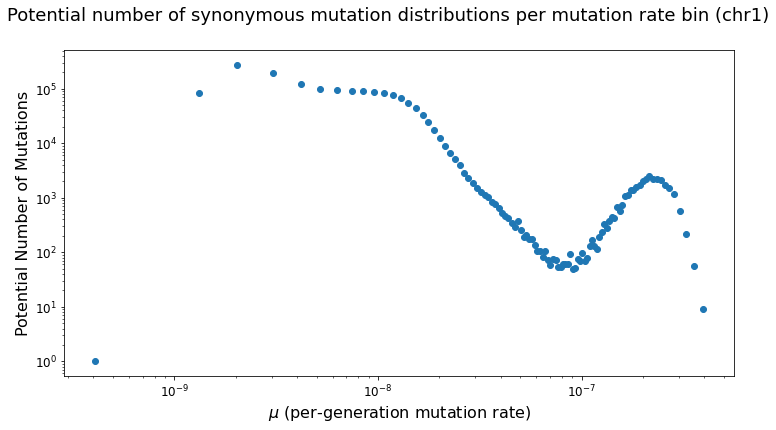

In [17]:
muBins = dfFilterQuality80.mu.unique()
muBins = np.sort(muBins)

dfMuBins = pd.DataFrame(data = muBins)
dfMuBins.columns = ['mu_bins']
print(len(dfMuBins))
print(dfMuBins.head())

freqMu = np.zeros(len(muBins))

for i in range(len(muBins)):
    dfFilterQuality80Plot = dfFilterQuality80[dfFilterQuality80['mu'] == muBins[i]]
    freqMu[i] = len(dfFilterQuality80Plot)
    
print(freqMu)

dfMuBins['freq'] = freqMu.tolist()

perGenConstant = 1.01482054e-7
dfMuBins['mu_bins'] = dfMuBins['mu_bins'] * perGenConstant

print(dfMuBins.head())

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
plt.xscale("log")
plt.yscale("log")
plt.scatter(dfMuBins['mu_bins'], dfMuBins['freq'])

fig.suptitle('Potential number of synonymous mutation distributions per mutation rate bin (chr1)', fontsize=18)

plt.xlabel('$\mu$ (per-generation mutation rate)',  fontsize=16)
plt.xticks(fontsize=12)

plt.ylabel('Potential Number of Mutations',  fontsize=16)
plt.yticks(fontsize=12)

In [18]:
#dfMuBins.to_csv('syn_mu_num_mutations.csv', index=False) #Uncomment this line to store df as a csv

In [19]:
dfFilterQuality80['covg_binary'] = [1 for x in range(len(dfFilterQuality80))]
dfFilterQuality80['covg_binary'] = np.where((dfFilterQuality80.over_20 <= 0.995), 0, dfFilterQuality80.covg_binary)

muBinsNew = dfFilterQuality80.mu.unique()
muBinsNew = np.sort(muBinsNew)
# propGIABFalseCpGFalse = np.zeros(len(muBins))
# propGIABTrueCpGFalse = np.zeros(len(muBins))
# propGIABFalseCpGTrue = np.zeros(len(muBins))
# propGIABTrueCpGTrue = np.zeros(len(muBins))

# for i in range(len(muBinsNew)):
#     fractionFreqGreater0 = 0
#     dfBinned = dfFilterQuality80[dfFilterQuality80['mu'] == muBinsNew[i]]
#     dfGIABFalse = dfBinned[dfBinned['GIAB'] == 0]
#     dfGIABTrue = dfBinned[dfBinned['GIAB'] == 1]
    
#     #GIAB = 0, CpG = 0
#     dfGIABFalseCpGFalse = dfGIABFalse[dfGIABFalse['CpG_context'] == 0] 
#     dfGreaterZero = dfGIABFalseCpGFalse[dfGIABFalseCpGFalse['freq'] > 0]
#     fractionFreqGreater0 = len(dfGreaterZero) / len(dfBinned)
#     propGIABFalseCpGFalse[i] = fractionFreqGreater0
    
#     #GIAB = 1, CpG = 0
#     fractionFreqGreater1 = 0
#     dfGIABTrueCpGFalse = dfGIABTrue[dfGIABTrue['CpG_context'] == 0]
#     dfGreaterZero1 = dfGIABTrueCpGFalse[dfGIABTrueCpGFalse['freq'] > 0]
#     fractionFreqGreater1 = len(dfGreaterZero1) / len(dfBinned)
#     propGIABTrueCpGFalse[i] = fractionFreqGreater1
    
#     #GIAB = 0, CpG = 1
#     fractionFreqGreater2 = 0
#     dfGIABFalseCpGTrue = dfGIABFalse[dfGIABFalse['CpG_context'] == 1] 
#     dfGreaterZero2 = dfGIABFalseCpGTrue[dfGIABFalseCpGTrue['freq'] > 0]
#     fractionFreqGreater2 = len(dfGreaterZero2) / len(dfBinned)
#     propGIABFalseCpGTrue[i] = fractionFreqGreater2
    
#     #GIAB = 1, CpG = 1
#     fractionFreqGreater3 = 0
#     dfGIABTrueCpGTrue = dfGIABTrue[dfGIABTrue['CpG_context'] == 1] 
#     dfGreaterZero3 = dfGIABTrueCpGTrue[dfGIABTrueCpGTrue['freq'] > 0]
#     fractionFreqGreater3 = len(dfGreaterZero2) / len(dfBinned)
#     propGIABTrueCpGTrue[i] = fractionFreqGreater3

# # dictionary0 = dict(zip(muBinsNew, propGIABFalseCpGFalse))
# # dictionary1 = dict(zip(muBinsNew, propGIABTrueCpGFalse))
# # dictionary2 = dict(zip(muBinsNew, propGIABFalseCpGTrue))
# # dictionary3 = dict(zip(muBinsNew, propGIABTrueCpGTrue))

# # dfFilterQuality80['prop_sites_GIABFalseCpGFalse'] = dfFilterQuality80['mu'].map(dictionary0)
# # dfFilterQuality80['prop_sites_GIABTrueCpGFalse'] = dfFilterQuality80['mu'].map(dictionary1)
# # dfFilterQuality80['prop_sites_GIABFalseCpGTrue'] = dfFilterQuality80['mu'].map(dictionary2)
# # dfFilterQuality80['prop_sites_GIABTrueCpGTrue'] = dfFilterQuality80['mu'].map(dictionary3)

# # dfFilterQuality80['mut_type'] = ['synonymous' for x in range(len(dfFilterQuality80))]

print(dfFilterQuality80.head())

# print(propGIABFalseCpGFalse)
# print(propGIABTrueCpGFalse)
# print(propGIABFalseCpGTrue)
# print(propGIABTrueCpGTrue)

     chrom     pos             gene ref alt      freq  freq_nfe     mu  qual  \
629      1  925947  ENSG00000187634   C   A  0.000000  0.000000  0.020  high   
630      1  925947  ENSG00000187634   C   G  0.000000  0.000000  0.041  high   
631      1  925947  ENSG00000187634   C   T  0.000004  0.000009  0.139  high   
632      1  925950  ENSG00000187634   G   A  0.000004  0.000009  0.163  high   
633      1  925953  ENSG00000187634   G   A  0.000000  0.000000  0.261  high   

    context  ...  rf_tp_probability_label  interp_dist  GIAB  CpG_context  \
629   TCCAA  ...                      NaN            0     1          0.0   
630   TCCAA  ...                      NaN            0     1          0.0   
631   TCCAA  ...                      NaN            0     1          0.0   
632   CCCTT  ...                      NaN            0     1          0.0   
633   ATCCC  ...                      NaN            0     1          0.0   

     logistic_freq    log_mu  log_mu_squared  GIAB_CpG_I

In [20]:
#print(dfFilterQuality80.columns)
print(dfFilterQuality80['median'].unique())
#dfFilterQuality80.to_csv('dfFilterQuality80Synonymous.csv', index = False)

[ 85  86  87  89  90  91  88  83  82  80  78  76  73  79  77  75  74  72
  71  68  69  70  84  67  66  64  62  61  60  58  55  54  52  50  48  46
  44  42  47  51  53  56  59  57  32  33  34  31  30  29  35  37  38  39
  40  43  45  49  63  65  28  27  81  93  94  96  97  99 100  98  95  92
  41  36  26]


In [21]:
propFFF = np.zeros(len(muBins))
for i in range(len(muBinsNew)):
    fractionFreqGreater0 = 0
    dfBinned0 = dfFilterQuality80[dfFilterQuality80['mu'] == muBinsNew[i]]
    dfF0 = dfBinned0[dfBinned0['GIAB'] == 0]
    dfFF0 = dfF0[dfF0['CpG_context'] == 0]
    
    #GIAB = 0, CpG = 0, Cov = 0
    dfFFF0 = dfFF0[dfFF0['covg_binary'] == 0] 
    dfGreaterZero = dfFFF0[dfFFF0['freq'] > 0]
    if (len(dfFFF0) != 0):
        fractionFreqGreater0 = len(dfGreaterZero) / len(dfFFF0)
    else:
        fractionFreqGreater0 = np.nan
    propFFF[i] = fractionFreqGreater0
    
print(propFFF)

dfMuBinsNew0 = pd.DataFrame(data = muBinsNew, columns=['mu_bins'])
dfMuBinsNew0['prop'] = propFFF.tolist() 
dfMuBinsNew0['GIAB'] = [0 for x in range(len(muBinsNew))]
dfMuBinsNew0['CpG_context'] = [0 for x in range(len(muBinsNew))]
dfMuBinsNew0['Cov'] = [0 for x in range(len(muBinsNew))]

print(dfMuBinsNew0.head())

[       nan 0.01819779 0.02698725 0.03980323 0.05347544 0.06753915
 0.08320624 0.0997014  0.11350865 0.12852503 0.13881683 0.14827908
 0.16111763 0.17571104 0.18511654 0.20437413 0.21539465 0.22390452
 0.23580563 0.22752613 0.27587844 0.28395821 0.27466456 0.30552424
 0.34097035 0.37924866 0.33409611 0.33333333 0.35028249 0.34328358
 0.41474654 0.40104167 0.46511628 0.3125     0.48201439 0.40384615
 0.45544554 0.50704225 0.41860465 0.44262295 0.48214286 0.43076923
 0.48076923 0.43661972 0.45945946 0.61290323 0.56       0.5
 0.48       0.72222222 0.4        0.52631579 0.46666667 0.75
 0.76923077 0.44444444 0.57142857 0.33333333 1.         0.8
        nan 1.         0.                nan 0.                nan
 0.                nan 1.         1.         1.                nan
 1.                nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan    

In [22]:
propTFF = np.zeros(len(muBins))
for i in range(len(muBinsNew)):
    fractionFreqGreater1 = 0
    dfBinned1 = dfFilterQuality80[dfFilterQuality80['mu'] == muBinsNew[i]]
    dfT1 = dfBinned1[dfBinned1['GIAB'] == 1]
    dfTF1 = dfT1[dfT1['CpG_context'] == 0]
    
    #GIAB = 0, CpG = 0, Cov = 0
    dfTFF1 = dfTF1[dfTF1['covg_binary'] == 0] 
    dfGreaterZero1 = dfTFF1[dfTFF1['freq'] > 0]
    if (len(dfTFF1) != 0):
        fractionFreqGreater1 = len(dfGreaterZero1) / len(dfTFF1)
    else: 
        fractionFreqGreater1 = np.nan
    propTFF[i] = fractionFreqGreater1

print(propTFF)

dfMuBinsNew1 = pd.DataFrame(data = muBinsNew, columns=['mu_bins'])
dfMuBinsNew1['prop'] = propTFF.tolist() 
dfMuBinsNew1['GIAB'] = [1 for x in range(len(muBinsNew))]
dfMuBinsNew1['CpG_context'] = [0 for x in range(len(muBinsNew))]
dfMuBinsNew1['Cov'] = [0 for x in range(len(muBinsNew))]

print(dfMuBinsNew1.head())

[       nan 0.01824888 0.02772143 0.04379562 0.05775775 0.07261864
 0.08405692 0.10351588 0.12219583 0.1298045  0.14691605 0.15363636
 0.16283925 0.18052779 0.18780774 0.20534591 0.23001567 0.22857143
 0.24614254 0.24294355 0.27624309 0.28548387 0.27069351 0.29855072
 0.32945736 0.25945946 0.3483871  0.30769231 0.41666667 0.35820896
 0.32075472 0.27906977 0.33333333 0.33333333 0.28571429 0.33333333
 0.41666667 0.6        0.2        0.41666667 0.5        0.75
 0.625      0.33333333 0.         0.5        0.         0.5
 0.75       0.66666667 1.         0.         0.5        0.
        nan 1.                nan        nan        nan 1.
        nan        nan        nan        nan        nan        nan
 0.                nan 1.                nan 1.                nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan  

In [23]:
propFTF = np.zeros(len(muBins))
for i in range(len(muBinsNew)):
    fractionFreqGreater2 = 0
    dfBinned2 = dfFilterQuality80[dfFilterQuality80['mu'] == muBinsNew[i]]
    dfF2 = dfBinned2[dfBinned2['GIAB'] == 0]
    dfFT2 = dfF2[dfF2['CpG_context'] == 1]
    
    #GIAB = 0, CpG = 0, Cov = 0
    dfFTF2 = dfFT2[dfFT2['covg_binary'] == 0] 
    dfGreaterZero2 = dfFTF2[dfFTF2['freq'] > 0]
    if (len(dfFTF2) != 0):
        fractionFreqGreater2 = len(dfGreaterZero2) / len(dfFTF2)
    else:
        fractionFreqGreater2 = np.nan
    propFTF[i] = fractionFreqGreater2

print(propFTF)

dfMuBinsNew2 = pd.DataFrame(data = muBinsNew, columns=['mu_bins'])
dfMuBinsNew2['prop'] = propFTF.tolist() 
dfMuBinsNew2['GIAB'] = [0 for x in range(len(muBinsNew))]
dfMuBinsNew2['CpG_context'] = [1 for x in range(len(muBinsNew))]
dfMuBinsNew2['Cov'] = [0 for x in range(len(muBinsNew))]

print(dfMuBinsNew2.head())

[       nan        nan        nan        nan        nan        nan
 0.         0.1576087  0.11775362 0.11554333 0.1481976  0.15326633
 0.14206128 0.15469146 0.18950437 0.136      0.21072797 0.21925134
 0.22018349 0.25581395 0.29577465 0.33766234 0.328125   0.22222222
 0.27272727 0.35       0.37931034 0.35897436 0.35135135 0.33783784
 0.42       0.48275862 0.4516129  0.44827586 0.54166667 0.39285714
 0.52941176 0.33333333 0.38235294 0.4137931  0.66666667 0.69230769
 0.77777778 0.6        0.71428571 0.5        0.83333333 1.
 0.8        0.66666667 0.42857143 0.5        0.7        0.85714286
 1.         0.8        0.6        0.63636364 0.59090909 0.86666667
 0.8        0.6875     0.84210526 0.84615385 0.84210526 0.6875
 0.68421053 0.69767442 0.84375    0.82142857 0.64705882 0.82857143
 0.79207921 0.77142857 0.80555556 0.86131387 0.90243902 0.88995215
 0.85714286 0.84415584 0.87947883 0.91594203 0.91358025 0.90092166
 0.9063745  0.90018832 0.9244373  0.91017964 0.91497006 0.93313522
 0.9455

In [24]:
propFFT = np.zeros(len(muBins))
for i in range(len(muBinsNew)):
    fractionFreqGreater3 = 0
    dfBinned3 = dfFilterQuality80[dfFilterQuality80['mu'] == muBinsNew[i]]
    dfF3 = dfBinned3[dfBinned3['GIAB'] == 0]
    dfFF3 = dfF3[dfF3['CpG_context'] == 0]
    
    #GIAB = 0, CpG = 0, Cov = 0
    dfFFT3 = dfFF3[dfFF3['covg_binary'] == 1] 
    dfGreaterZero3 = dfFFT3[dfFFT3['freq'] > 0]
    if (len(dfFFT3) != 0):
        fractionFreqGreater3 = len(dfGreaterZero3) / len(dfFFT3)
    else:
        fractionFreqGreater3 = np.nan
    propFFT[i] = fractionFreqGreater3

print(propFFT)

dfMuBinsNew3 = pd.DataFrame(data = muBinsNew, columns=['mu_bins'])
dfMuBinsNew3['prop'] = propFFT.tolist() 
dfMuBinsNew3['GIAB'] = [0 for x in range(len(muBinsNew))]
dfMuBinsNew3['CpG_context'] = [0 for x in range(len(muBinsNew))]
dfMuBinsNew3['Cov'] = [1 for x in range(len(muBinsNew))]

print(dfMuBinsNew3.head())

[0.         0.018819   0.02783578 0.03936563 0.05392543 0.06973255
 0.08510906 0.0987248  0.11572116 0.12802147 0.14161052 0.15375222
 0.17000411 0.17938759 0.19177107 0.2107055  0.21216717 0.23235397
 0.2381606  0.25372769 0.27075099 0.27341137 0.28229937 0.30111821
 0.34065934 0.32572877 0.34364261 0.37354086 0.42222222 0.37650602
 0.41233766 0.40254237 0.40725806 0.48421053 0.38857143 0.42553191
 0.46610169 0.47368421 0.58888889 0.5        0.60273973 0.4
 0.42857143 0.46296296 0.44186047 0.40740741 0.65714286 0.6875
 0.54545455 0.44       0.5        0.5        0.5        0.55555556
 0.4        0.64285714 0.75       0.8        0.71428571 0.66666667
 1.         1.         1.                nan 1.         0.5
 0.                nan 0.                nan        nan 1.
 1.                nan 1.                nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        na

In [25]:
propTTF = np.zeros(len(muBins))
for i in range(len(muBinsNew)):
    fractionFreqGreater4 = 0
    dfBinned4 = dfFilterQuality80[dfFilterQuality80['mu'] == muBinsNew[i]]
    dfT4 = dfBinned4[dfBinned4['GIAB'] == 1]
    dfTT4 = dfT4[dfT4['CpG_context'] == 1]
    
    #GIAB = 0, CpG = 0, Cov = 0
    dfTTF4 = dfTT4[dfTT4['covg_binary'] == 0] 
    dfGreaterZero4 = dfTTF4[dfTTF4['freq'] > 0]
    if (len(dfTTF4) != 0):
        fractionFreqGreater4 = len(dfGreaterZero4) / len(dfTTF4)
    else:
        fractionFreqGreater4 = np.nan
    propTTF[i] = fractionFreqGreater4

print(propTTF)

dfMuBinsNew4 = pd.DataFrame(data = muBinsNew, columns=['mu_bins'])
dfMuBinsNew4['prop'] = propTTF.tolist() 
dfMuBinsNew4['GIAB'] = [1 for x in range(len(muBinsNew))]
dfMuBinsNew4['CpG_context'] = [1 for x in range(len(muBinsNew))]
dfMuBinsNew4['Cov'] = [0 for x in range(len(muBinsNew))]

print(dfMuBinsNew4.head())

[       nan        nan        nan        nan        nan        nan
 0.         0.11764706 0.12217195 0.11570248 0.15566038 0.13232104
 0.15279503 0.18791946 0.17048346 0.2345679  0.22282609 0.16489362
 0.19259259 0.19463087 0.22580645 0.3115942  0.29801325 0.21238938
 0.24390244 0.33103448 0.30555556 0.27559055 0.26041667 0.31927711
 0.30909091 0.28125    0.36170213 0.38823529 0.51020408 0.33766234
 0.44642857 0.42592593 0.43010753 0.36734694 0.36666667 0.34482759
 0.42857143 0.32       0.39130435 0.4375     0.45       0.71428571
 0.47619048 0.125      0.33333333 0.58823529 0.38461538 0.64285714
 0.7        0.53333333 0.66666667 0.64285714 0.5        0.55555556
 0.6        0.76923077 0.57692308 0.80645161 0.65       0.69565217
 0.78571429 0.50943396 0.57142857 0.8125     0.56862745 0.65384615
 0.75806452 0.64788732 0.83050847 0.78333333 0.82191781 0.68852459
 0.81481481 0.8018018  0.84563758 0.82926829 0.87939698 0.83111111
 0.90212766 0.90666667 0.9280303  0.92832765 0.91066282 0.8990

In [26]:
propFTT = np.zeros(len(muBins))
for i in range(len(muBinsNew)):
    fractionFreqGreater5 = 0
    dfBinned5 = dfFilterQuality80[dfFilterQuality80['mu'] == muBinsNew[i]]
    dfF5 = dfBinned5[dfBinned5['GIAB'] == 0]
    dfFT5 = dfF5[dfF5['CpG_context'] == 1]
    
    #GIAB = 0, CpG = 0, Cov = 0
    dfFTT5 = dfFT5[dfFT5['covg_binary'] == 1] 
    dfGreaterZero5 = dfFTT5[dfFTT5['freq'] > 0]
    if (len(dfFTT5) != 0):
        fractionFreqGreater5 = len(dfGreaterZero5) / len(dfFTT5)
    else:
        fractionFreqGreater5 = np.nan
    propFTT[i] = fractionFreqGreater5

print(propFTT)

dfMuBinsNew5 = pd.DataFrame(data = muBinsNew, columns=['mu_bins'])
dfMuBinsNew5['prop'] = propFTT.tolist() 
dfMuBinsNew5['GIAB'] = [0 for x in range(len(muBinsNew))]
dfMuBinsNew5['CpG_context'] = [1 for x in range(len(muBinsNew))]
dfMuBinsNew5['Cov'] = [1 for x in range(len(muBinsNew))]

print(dfMuBinsNew5.head())

[       nan        nan        nan        nan        nan        nan
 0.06896552 0.15708812 0.13448276 0.12739965 0.13464912 0.1539961
 0.16075246 0.15879828 0.17630597 0.19213313 0.20971302 0.20216606
 0.29281768 0.16447368 0.19166667 0.26966292 0.23611111 0.25862069
 0.22077922 0.19512195 0.31372549 0.41463415 0.43902439 0.33333333
 0.46666667 0.5        0.35       0.45238095 0.24       0.51851852
 0.53846154 0.31578947 0.46296296 0.46666667 0.61538462 0.5
 0.55555556 0.375      0.46666667 0.78947368 0.55555556 0.71428571
 0.61538462 0.71428571 0.66666667 0.75       0.69230769 0.83333333
 0.44444444 0.66666667 0.73333333 0.77777778 0.77272727 0.75
 0.76190476 0.81818182 0.63157895 0.80645161 0.84615385 0.78125
 0.79591837 0.70175439 0.83333333 0.93617021 0.78947368 0.8019802
 0.8880597  0.864      0.83428571 0.85781991 0.84803922 0.86024845
 0.88461538 0.88793103 0.88761905 0.91208791 0.90077519 0.89908257
 0.90105541 0.91980559 0.93451143 0.94090909 0.9379715  0.9348659
 0.95656192 0.

In [27]:
propTFT = np.zeros(len(muBins))
for i in range(len(muBinsNew)):
    fractionFreqGreater6 = 0
    dfBinned6 = dfFilterQuality80[dfFilterQuality80['mu'] == muBinsNew[i]]
    dfT6 = dfBinned6[dfBinned6['GIAB'] == 1]
    dfTF6 = dfT6[dfT6['CpG_context'] == 0]
    
    #GIAB = 0, CpG = 0, Cov = 0
    dfTFT6 = dfTF6[dfTF6['covg_binary'] == 1] 
    dfGreaterZero6 = dfTFT6[dfTFT6['freq'] > 0]
    if (len(dfTFT6) != 0): 
        fractionFreqGreater6 = len(dfGreaterZero6) / len(dfTFT6)
    else: 
        fractionFreqGreater6 = np.nan
    propTFT[i] = fractionFreqGreater6

print(propTFT)

dfMuBinsNew6 = pd.DataFrame(data = muBinsNew, columns=['mu_bins'])
dfMuBinsNew6['prop'] = propTFT.tolist() 
dfMuBinsNew6['GIAB'] = [1 for x in range(len(muBinsNew))]
dfMuBinsNew6['CpG_context'] = [0 for x in range(len(muBinsNew))]
dfMuBinsNew6['Cov'] = [1 for x in range(len(muBinsNew))]

print(dfMuBinsNew6.head())

[       nan 0.01772064 0.0293148  0.04326462 0.05417197 0.06311132
 0.09010989 0.10377608 0.11968296 0.13939552 0.14750542 0.15783133
 0.16525853 0.18368932 0.21065145 0.20595383 0.22601626 0.21630435
 0.27777778 0.28344671 0.2797619  0.26293103 0.31840796 0.30718954
 0.30841121 0.34       0.33823529 0.44444444 0.34042553 0.34210526
 0.42307692 0.17647059 0.52380952 0.45       0.46666667 0.
 0.09090909 0.5        0.         0.25       0.5        0.5
 0.83333333 0.66666667 0.5        0.5        0.33333333 1.
 1.         1.         0.         1.         0.5        1.
 0.         0.         0.         0.5        1.                nan
        nan        nan 1.                nan        nan 1.
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan 

In [28]:
propTTT = np.zeros(len(muBins))
for i in range(len(muBinsNew)):
    fractionFreqGreater7 = 0
    dfBinned7 = dfFilterQuality80[dfFilterQuality80['mu'] == muBinsNew[i]]
    dfT7 = dfBinned7[dfBinned7['GIAB'] == 1]
    dfTT7 = dfT7[dfT7['CpG_context'] == 1]
    
    #GIAB = 0, CpG = 0, Cov = 0
    dfTTT7 = dfTT7[dfTT7['covg_binary'] == 1] 
    dfGreaterZero7 = dfTTT7[dfTTT7['freq'] > 0]
    if (len(dfTTT7) != 0):
        fractionFreqGreater7 = len(dfGreaterZero7) / len(dfTTT7)
    else: 
        fractionFreqGreater7 = np.nan
    propTTT[i] = fractionFreqGreater7

print(propTTT)

dfMuBinsNew7 = pd.DataFrame(data = muBinsNew, columns=['mu_bins'])
dfMuBinsNew7['prop'] = propTTT.tolist() 
dfMuBinsNew7['GIAB'] = [1 for x in range(len(muBinsNew))]
dfMuBinsNew7['CpG_context'] = [1 for x in range(len(muBinsNew))]
dfMuBinsNew7['Cov'] = [1 for x in range(len(muBinsNew))]

print(dfMuBinsNew7.head())

[       nan        nan        nan        nan        nan        nan
        nan 0.14285714 0.07291667 0.1119403  0.14532872 0.12232416
 0.17325228 0.18149466 0.17058824 0.24242424 0.13580247 0.21875
 0.44827586 0.16666667 0.13043478 0.45833333 0.28       0.42857143
 0.42857143 0.2962963  0.14285714 0.42857143 0.29411765 0.34782609
 0.35       0.43478261 0.53846154 0.5        0.33333333 0.42105263
 0.55555556 0.58333333 0.42857143 0.44444444 0.28571429 0.53846154
 0.57142857 1.         0.83333333 0.5        0.5        1.
 0.5        0.25       0.5        1.         0.66666667 0.66666667
 1.         0.5        0.75       0.42857143 0.2        0.
 0.4        0.75       1.         0.7        0.66666667 0.8
 0.8        0.78571429 0.90909091 0.77777778 0.81818182 0.85714286
 0.69230769 0.86666667 0.88461538 0.83333333 0.81818182 0.72972973
 0.87096774 0.9        0.87912088 0.87878788 0.86746988 0.91836735
 0.9        0.91869919 0.88652482 0.91304348 0.88961039 0.91566265
 0.92622951 0.9      

In [29]:
dfMuBinsNewAll = pd.concat([dfMuBinsNew0, dfMuBinsNew1, dfMuBinsNew2, dfMuBinsNew3, dfMuBinsNew4, dfMuBinsNew5, dfMuBinsNew6, dfMuBinsNew7])
print(len(dfMuBinsNewAll))
print(dfMuBinsNewAll.head())
dfMuBinsNewAllDrop = dfMuBinsNewAll.dropna(axis='rows')
print(len(dfMuBinsNewAllDrop))
print(dfMuBinsNewAllDrop.head())

792
   mu_bins      prop  GIAB  CpG_context  Cov
0    0.004       NaN     0            0    0
1    0.013  0.018198     0            0    0
2    0.020  0.026987     0            0    0
3    0.030  0.039803     0            0    0
4    0.041  0.053475     0            0    0
626
   mu_bins      prop  GIAB  CpG_context  Cov
1    0.013  0.018198     0            0    0
2    0.020  0.026987     0            0    0
3    0.030  0.039803     0            0    0
4    0.041  0.053475     0            0    0
5    0.051  0.067539     0            0    0


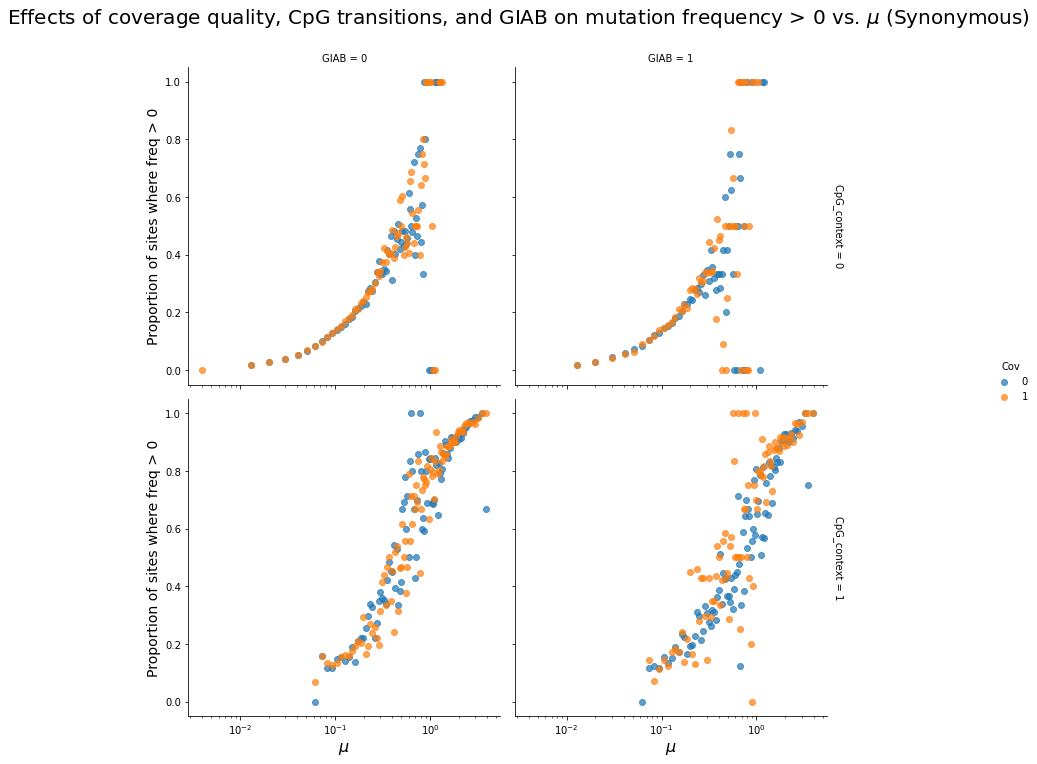

In [30]:
g = sns.FacetGrid(dfMuBinsNewAllDrop, row = "CpG_context", col="GIAB", hue = "Cov", height=5, aspect=1, margin_titles=True)
g.set(xscale="log")
g.map(plt.scatter, "mu_bins", "prop", alpha=.7)
#plt.xlabel('', fontsize=16)
#plt.ylabel('', fontsize=16)
g.axes[1,0].set_xlabel('$\mu$', fontsize = 16)
g.axes[1,1].set_xlabel('$\mu$', fontsize = 16)
g.axes[0,0].set_ylabel('Proportion of sites where freq > 0', fontsize = 14)
g.axes[1,0].set_ylabel('Proportion of sites where freq > 0', fontsize = 14)
g.fig.suptitle('Effects of coverage quality, CpG transitions, and GIAB on mutation frequency > 0 vs. $\mu$ (Synonymous)', y=1.05, fontsize=20)
g.add_legend()

In [31]:
#dfFilterQuality80.to_csv('syn_effects_plot.csv', index=False) #Uncomment this line to store df as a csv